Выполнила: Блинова Елена М., КЭ-128

Вариант: 2 (алгоритм логистической регрессии)

# Анализ почтовых сервисов методами ИИ
Данная работа включает следующие основные разделы:
- импорт используемых библиотек
- описание набора данных
- предварительная обработка данных
- создание и обучение модели
- документация

### Описание набора данных

Исходный набор даных: Spam or Not Spam Dataset (https://www.kaggle.com/datasets/ozlerhakan/spam-or-not-spam-dataset)

В наборе данных содержится 2500 неспам-сообщений и 500 спам-сообщений.

Набор данных состоит из одного файла: spam_or_not_spam.csv

Целью данной работы является бинарная классификация сообщений с помощью алгоритма логистической регрессии.

## Импорт используемых библиотек

In [ ]:
# Модуль для взаимодействия с файловой системой
import os
# Библиотека для работы с данными
import pandas as pd

# Импорт библиотеки для создания облаков слов, визуального представления частоты слов в тексте
from wordcloud import WordCloud
# Импорт библиотеки для создания визуализаций
import matplotlib.pyplot as plt
# Импорт библиотеки seaborn для создания статистических графиков, основанных на matplotlib
import seaborn as sns
# Импорт функции для разделения набора данных на тренировочные и тестовые наборы
from sklearn.model_selection import train_test_split

# Библиотека для работы с регулярными выражениями
import re

# Библиотека для обработки естественного языка
import nltk
# stopwords - список слов для исключения из текста
from nltk.corpus import stopwords
# модули для стемминга и лемматизации для перевода слов к базовой форме
from nltk.stem import PorterStemmer, WordNetLemmatizer
# функция, которая разбивает текст на отдельные слова (токенизация)
from nltk.tokenize import word_tokenize

# Загрузка списка стоп-слов для английского языка из библиотеки NLTK
nltk.download('stopwords')
# Загрузка модуля для токенизации текста, который используется для разбиения текста на слова
nltk.download('punkt')
# Загрузка лемматизатора WordNet, который используется для приведения слов к их базовой форме
nltk.download('wordnet')

# для поиска оптимальных гиперпараметров модели с использованием кросс-валидации
from sklearn.model_selection import GridSearchCV
# для создания модели логистической регрессии
from sklearn.linear_model import LogisticRegression
# для стандартизации признаков набора данных
from sklearn.preprocessing import StandardScaler
# для последовательного выполнения нескольких шагов обработки и моделирования
from sklearn.pipeline import Pipeline
# для преобразования текста в числовые признаки с использованием TF-IDF (Term Frequency-Inverse Document Frequency)
from sklearn.feature_extraction.text import TfidfVectorizer
# classification_report для создания отчета по метрикам классификации
# accuracy_score для вычисления точности модели
from sklearn.metrics import classification_report, accuracy_score
# joblib для сохранения и загрузки обученных моделей
import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Подключение к гугл диску

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Предварительная обработка данных
- загрузка и визуализация данных
- разделение данных на тренировочный, тестовый и валидационный наборы

### Загрузка данных

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Dataset')
df = pd.read_csv('spam_or_not_spam.csv')

In [ ]:
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


Имеется одно пропущенное значение

In [ ]:
# Удаление записей с пустыми значениями в столбце 'email'
df_clean = df.dropna(subset=['email'])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2999 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   2999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.3+ KB


In [ ]:
# Получение уникальных значений в столбце 'label'
unique_labels = df_clean['label'].unique()
unique_labels

array([0, 1])

In [ ]:
# Подсчет количества значений для каждого уникального значения в столбце 'label'
label_counts = df_clean['label'].value_counts()
label_counts

,count
label,
0,2500
1,499


- 1 - если сообщение является спамом
- 0 - не является спамом

### Нормализация данных

Далее осуществляется:

- Приведение к нижнему регистру
- Очистка от «мусора», спецсимволов, опечаток, слов с неправильной кодировкой, знаков пунктуации.
- Удаление стоп‑слов
- Стемминг/ лемматизация слов. Стемминг — это процесс нахождения основы слова, а лемматизация — процесс нахождения нормальной формы слова.

In [ ]:
# Создание объектов для стемминга и лемматизации
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, use_stemming=False):
    # Приведение к нижнему регистру
    text = text.lower()

    # Очистка текста от спецсимволов и знаков пунктуации
    text = re.sub(r'[^\w\s]', '', text)

    # Токенизация текста
    tokens = word_tokenize(text)

    # Удаление стоп-слов
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    # Стемминг или лемматизация
    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    else:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Объединение токенов в строку
    processed_text = ' '.join(tokens)

    return processed_text

In [ ]:
def preprocess_text_simple(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Очистка текста от спецсимволов и знаков пунктуации
    text = re.sub(r'[^\w\s]', '', text)

    return text

In [ ]:
# использование стемминг
df_normal_stemmer = df_clean.copy()
df_normal_stemmer['email'] = df_normal_stemmer['email'].apply(lambda x: preprocess_text(x, use_stemming=True))
df_normal_stemmer.head()

,email,label
0,date wed number aug number number number numbe...,0
1,martin post tasso papadopoulo greek sculptor b...,0
2,man threaten explos moscow thursday august num...,0
3,klez viru die alreadi prolif viru ever klez co...,0
4,ad cream spaghetti carbonara effect pasta make...,0


In [ ]:
# Применение лемматизации
df_normal_lemmatizer = df_clean.copy()
df_normal_lemmatizer['email'] = df_normal_lemmatizer['email'].apply(lambda x: preprocess_text(x, use_stemming=False))
df_normal_lemmatizer.head()

,email,label
0,date wed number aug number number number numbe...,0
1,martin posted tasso papadopoulos greek sculpto...,0
2,man threatens explosion moscow thursday august...,0
3,klez virus die already prolific virus ever kle...,0
4,adding cream spaghetti carbonara effect pasta ...,0


In [ ]:
df_normal = df_clean.copy()
df_normal['email'] = df_normal['email'].apply(preprocess_text_simple)
df_normal.head()

,email,label
0,date wed number aug number number number numb...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


### Визуализация данных

In [ ]:
def generate_wordclouds(df, text_column, label_column):
    # Разделение данных на спам и не спам
    spam = df[df[label_column] == 1]
    not_spam = df[df[label_column] == 0]

    # Создание текста для спам и не спам сообщений
    spam_words = ' '.join(spam[text_column])
    not_spam_words = ' '.join(not_spam[text_column])

    # Создание множества слов из не спам сообщений
    not_spam_set = set(not_spam_words.split())

    # Удаление слов из спам, которые также встречаются в не спам
    spam_filtered_words = ' '.join(word for word in spam_words.split() if word not in not_spam_set)

    # Визуализация облака слов для спам сообщений
    wordcloud_spam = WordCloud(width=600, height=350, background_color='white').generate(spam_filtered_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.axis('off')
    plt.title('Облако слов для спам (исключая слова из не спам)')
    plt.show()

    # Визуализация облака слов для не спам сообщений
    wordcloud_not_spam = WordCloud(width=800, height=400, background_color='white').generate(not_spam_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_not_spam, interpolation='bilinear')
    plt.axis('off')
    plt.title('Облако слов для не спам')
    plt.show()

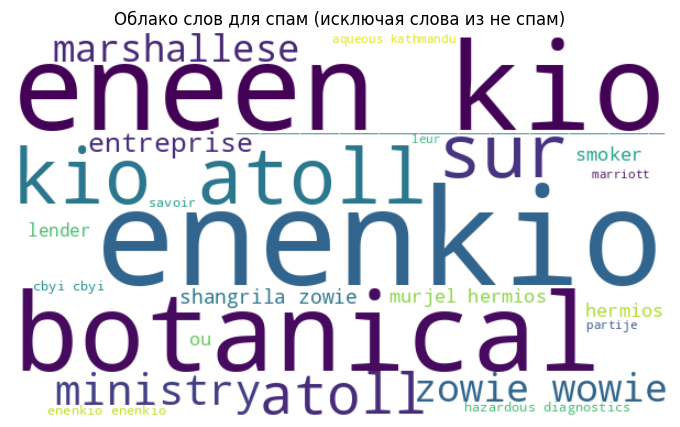

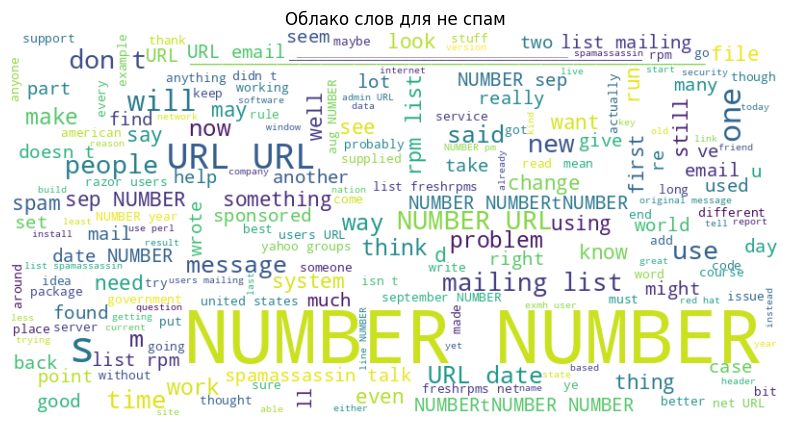

In [ ]:
generate_wordclouds(df_clean, 'email', 'label')

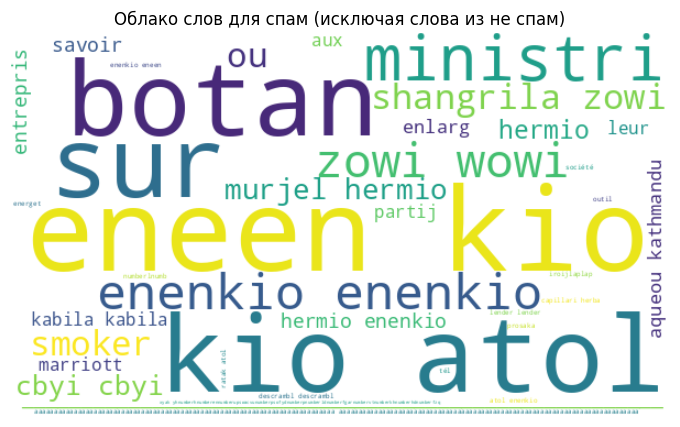

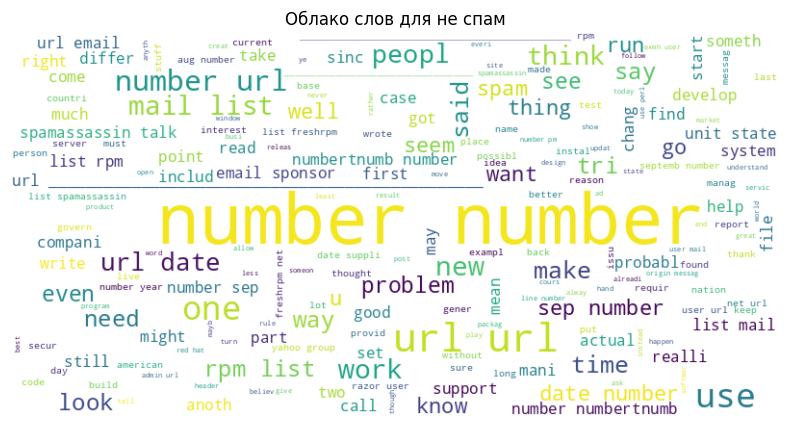

In [ ]:
generate_wordclouds(df_normal_stemmer, 'email', 'label')

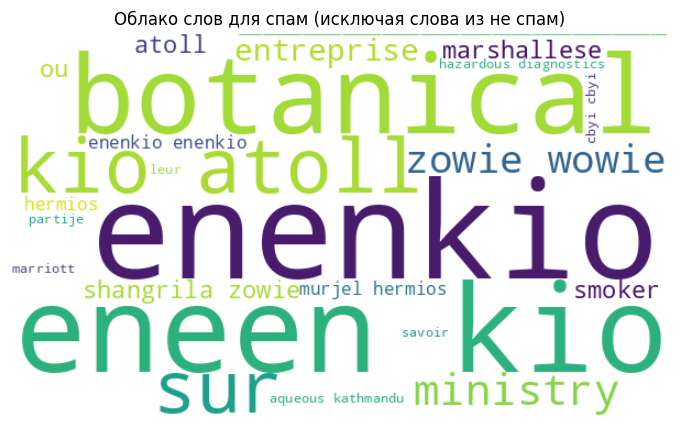

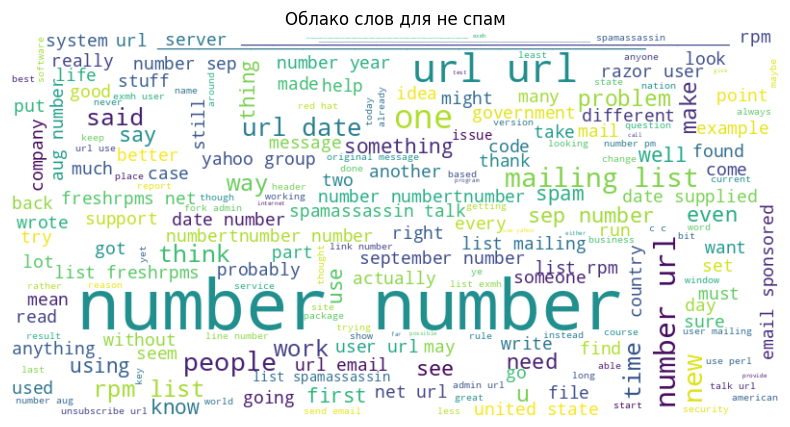

In [ ]:
generate_wordclouds(df_normal_lemmatizer, 'email', 'label')

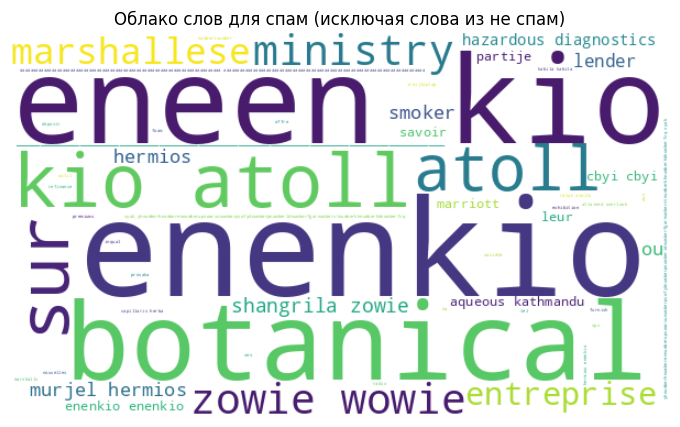

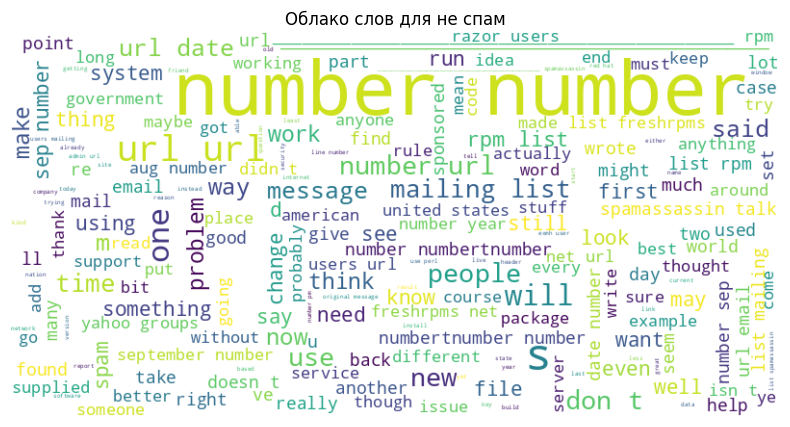

In [ ]:
generate_wordclouds(df_normal, 'email', 'label')

### Разделение данных на тренировочный и тестовый наборы

In [ ]:
def split_data_with_proportion(df, test_size=0.2, random_state=42, isPrint=False):
    """
    Разделяет данные на тренировочный и тестовый наборы с сохранением исходной пропорции классов.

    Parameters:
    df (DataFrame): Исходный DataFrame.
    test_size (float): Доля данных, выделяемых для тестового набора (по умолчанию 0.2)
    random_state (int): Параметр для воспроизводимости результатов (по умолчанию 42).

    Returns:
    DataFrame, DataFrame: Тренировочный и тестовый наборы данных.
    """

    # Разделение данных на признаки (X) и целевую переменную (y)
    X = df.drop(columns=['label'])
    y = df['label']

    # Разделение данных с учетом исходной пропорции классов
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Создание тренировочного и тестового DataFrame
    train_df = X_train.copy()
    train_df['label'] = y_train
    test_df = X_test.copy()
    test_df['label'] = y_test
    if isPrint:
      print(f"Размер исходного набора данных: {df.shape}\n")
      print(f"Пропорции классов в исходном наборе:\n{y.value_counts(normalize=True)}\n")

      print(f"Размер тренировочного набора: {train_df.shape}")
      print(f"Размер тестового набора: {test_df.shape}")
      print(f"Пропорции классов в тренировочном наборе:\n{train_df['label'].value_counts(normalize=True)}")
      print(f"Пропорции классов в тестовом наборе:\n{test_df['label'].value_counts(normalize=True)}")

    return train_df, test_df

In [ ]:
# разбиение данных
train_df, test_df = split_data_with_proportion(df_clean, test_size=0.2, isPrint=True)

Размер исходного набора данных: (2999, 2)

Пропорции классов в исходном наборе:
label
0    0.833611
1    0.166389
Name: proportion, dtype: float64

Размер тренировочного набора: (2399, 2)
Размер тестового набора: (600, 2)
Пропорции классов в тренировочном наборе:
label
0    0.833681
1    0.166319
Name: proportion, dtype: float64
Пропорции классов в тестовом наборе:
label
0    0.833333
1    0.166667
Name: proportion, dtype: float64


## Создание модели логистической регрессии

In [ ]:
# Метод для создания модели логистической регрессии
def create_logistic_regression_model(df_list, param_grid=None, test_size=0.2, random_state=42):
    """
    Создание и обучение модели логистической регрессии с использованием Grid Search для нескольких DataFrame.

    Parameters:
    df_list (list): Список DataFrame.
    param_grid (dict): Словарь с параметрами для Grid Search.
    test_size (float): Доля данных, выделяемых для тестового набора (по умолчанию 0.2).
    random_state (int): Параметр для воспроизводимости результатов (по умолчанию 42).

    Returns:
    DataFrame: Таблица с результатами обучения моделей для каждого DataFrame.
    """
    results = []

    for idx, df in enumerate(df_list):
        # Разделение данных на тренировочный и тестовый наборы
        train_df, test_df = split_data_with_proportion(df, test_size=test_size, random_state=random_state, isPrint=False)

        # Определение признаков и целевой переменной
        X_train = train_df.drop(columns=['label'])
        y_train = train_df['label']
        X_test = test_df.drop(columns=['label'])
        y_test = test_df['label']

        # Создание конвейера (pipeline) для преобразования текста и логистической регрессии
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),  # Преобразование текста в числовые признаки
            ('scaler', StandardScaler(with_mean=False)),  # Масштабирование данных
            ('logreg', LogisticRegression(max_iter=1000))  # Логистическая регрессия с увеличенным числом итераций
        ])

        # Проведение решетчатого поиска
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train['email'], y_train)

        # Выбор лучших параметров и оценка модели
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_

        # Вычисление точности на тренировочном и тестовом наборах данных
        train_accuracy = best_model.score(X_train['email'], y_train)
        test_accuracy = best_model.score(X_test['email'], y_test)

        # Сохранение модели в файл
        model_filename = f'model_df_{idx}.joblib'
        joblib.dump(best_model, model_filename)

        # Добавление результатов в таблицу
        results.append({
            'DataFrame': f'DataFrame_{idx}',
            'logreg__C': best_params['logreg__C'],
            'logreg__solver': best_params['logreg__solver'],
            'Train Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy,
            'Model Filename': model_filename
        })

        # Печать отчета по классификации для тестового набора данных
        y_pred = best_model.predict(X_test['email'])
        print(f"Отчет по классификации для DataFrame {idx}:\n{classification_report(y_test, y_pred)}")

    # Создание DataFrame с результатами
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
# Пример использования метода для нескольких DataFrame
df_list = [df_clean, df_normal, df_normal_lemmatizer, df_normal_stemmer]
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__solver': ['lbfgs', 'liblinear']
}

# Вызываем метод для обучения моделей на всех DataFrame из списка
results_df = create_logistic_regression_model(df_list, param_grid=param_grid)

# Печать таблицы с результатами
print(results_df)

Отчет по классификации для DataFrame 0:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       500
           1       0.96      0.91      0.93       100

    accuracy                           0.98       600
   macro avg       0.97      0.95      0.96       600
weighted avg       0.98      0.98      0.98       600

Отчет по классификации для DataFrame 1:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       500
           1       0.96      0.91      0.93       100

    accuracy                           0.98       600
   macro avg       0.97      0.95      0.96       600
weighted avg       0.98      0.98      0.98       600

Отчет по классификации для DataFrame 2:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       500
           1       0.94      0.92      0.93       100

    accuracy                           0.98       600
   macro

In [ ]:
print(results_df)

     DataFrame  logreg__C logreg__solver  Train Accuracy  Test Accuracy  \
0  DataFrame_0        1.0      liblinear        1.000000       0.978333   
1  DataFrame_1        1.0      liblinear        1.000000       0.978333   
2  DataFrame_2       10.0      liblinear        1.000000       0.976667   
3  DataFrame_3        0.1      liblinear        0.999166       0.976667   

      Model Filename  
0  model_df_0.joblib  
1  model_df_1.joblib  
2  model_df_2.joblib  
3  model_df_3.joblib  


In [ ]:
# Загрузка модели
model_filename = 'model_df_3.joblib'
model = joblib.load(model_filename)

# Тексты для классификации
messages = [
    "Congratulations! You have won a $1,000,000 lottery prize! To claim your prize, please click the link and fill out your details. Don't miss this chance to become a millionaire! Click here: [malicious link]",
    "Dear user, we have noticed suspicious activity on your account. Please verify your information immediately to avoid account suspension. Click here to verify: [malicious link]",
    "You have been selected to receive a free gift card worth $500! Claim your reward now by clicking the link below. Limited time offer! Click here: [malicious link]",
    "Urgent: Your account has been compromised. Click the link to reset your password and secure your account: [malicious link]",

    "Hey John, just wanted to check in and see how you're doing. It's been a while since we last caught up. Let's grab coffee soon!",
    "Hi team, please find attached the minutes from our last meeting. Let me know if there are any updates or changes required.",
    "Good morning, here is the weekly report on the project status. We are making good progress and are on track to meet our deadlines.",
    "Hello everyone, don't forget about the company picnic this Saturday. Bring your family and enjoy a day of fun activities and great food!"
]

# Преобразование текста и классификация
predictions = model.predict(messages)

# Печать результатов
for message, prediction in zip(messages, predictions):
    print(f"Сообщение: {message}")
    print("Классифицировано как:", "Спам" if prediction == 1 else "Не спам")
    print()


Сообщение: Congratulations! You have won a $1,000,000 lottery prize! To claim your prize, please click the link and fill out your details. Don't miss this chance to become a millionaire! Click here: [malicious link]
Классифицировано как: Спам

Сообщение: Dear user, we have noticed suspicious activity on your account. Please verify your information immediately to avoid account suspension. Click here to verify: [malicious link]
Классифицировано как: Спам

Сообщение: You have been selected to receive a free gift card worth $500! Claim your reward now by clicking the link below. Limited time offer! Click here: [malicious link]
Классифицировано как: Спам

Сообщение: Urgent: Your account has been compromised. Click the link to reset your password and secure your account: [malicious link]
Классифицировано как: Спам

Сообщение: Hey John, just wanted to check in and see how you're doing. It's been a while since we last caught up. Let's grab coffee soon!
Классифицировано как: Не спам

Сообщение:

## Документация

Было проведенно сравнение моделей логистической регрессии на разных вариантах предобработки данных с подбором оптимальных параметров с помощью решетчатого поиска (Grid Search).

Были использованы следующие параметры Grid Search:
- logreg__C: [0.01, 0.1, 1, 10]
- logreg__solver: ['lbfgs', 'liblinear']

logreg__C - это параметр, который контролирует регуляризацию модели, добавляя штраф за большие параметры (чем больше C, тем меньше регуляризация). Чем меньше регуляризация, тем сильнее модель подгоняет данные.

logreg__solver - это параметр, определяющий алгоритм оптимизации функции потерь в логистической регрессии:
- lbfgs (лимитированная память для алгоритма Бройдена-Флетчера-Гольдфарба-Шанно - )
- liblinear (использует библиотеку для линейной оптимизации)

Модель тестировалась на четырех разных вариантах предобработки данных:
1. Ненормализованные данные (DataFrame_0): Исходный набор данных без какой-либо предобработки.
2. Нормализованные данные простым способом (DataFrame_1): Данные, приведенные к нижнему регистру и очищенные от специальных символов.
3. Нормализованные данные с помощью лемматизации (DataFrame_2): Данные, обработанные с использованием лемматизации, приведение слов к базовой форме.
4. Нормализованные данные с помощью стемминга (DataFrame_3): Данные, обработанные с использованием стемминга, обрезание слов до их корня.

**Анализ полученных результатов**
- Train Accuracy: модели на различных наборах данных показали высокую точность на тренировочном наборе данных, близкую к 100%, что указывает на хорошую производительность на обучении, но не исключает возможность переобучения при получении результата ровно 100% - это может означать, что модель слишком хорошо адаптировалась под обучающую выборку, и на реальных данных может показывать некорректный результат.

- Test Accuracy: Точность на тестовом наборе данных немного различалась, но все модели показали высокую точность в диапазоне 97.667% - 97.833%.


**Лучшие параметры**
1. Для DataFrame_0 и DataFrame_1 наилучшие параметры были logreg__C: 1.0 и logreg__solver: liblinear.

2. Для DataFrame_2 лучшие параметры были logreg__C: 10.0 и logreg__solver: liblinear.

3. Для DataFrame_3 лучшие параметры были logreg__C: 0.1 и logreg__solver: liblinear.


**Вывод**

Предпочтение было отдано модели DataFrame_3, поскольку Train Accuracy не равен 100%. Данная модель корректно распознает поданные ей случайные письма как "спам - не спам"